# Topic Modeling

This notebook will document step by step different approaches to group documents in different topics using the **topic modeling** strategy.

## What exactly is Topic Modeling?

**Topic Modeling** is a technique used to discover the **distribution of uderlying topics** in a collection of documents.

Each topic is a collection of co-occuring words in a set of documents. The order of the words is not taken into account.

In [1]:
# Obtain the abstracts of the papers under data/pdfs

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
os.path.dirname(os.getcwd())

from pdf_analyzer.config_load import load_config
from pdf_analyzer.api import API
from omegaconf import OmegaConf
from pdf_analyzer.config_load import load_config

from get_paper_metadata import get_paper_metadata

In [2]:
server_config = load_config("config/api/grobid-server-config.yaml")
extract_config = load_config("config/api/api-base-config.yaml")
print("SERVER_CONFIG\n"+OmegaConf.to_yaml(server_config))
print("CLOUD_CONFIG\n"+OmegaConf.to_yaml(extract_config))

base_api = API.BaseAPI(extract_config,server_config)

abstracts = [get_paper_metadata(doc)['abstract'].strip() for doc in base_api.proccesed_files]

SERVER_CONFIG
url:
  protocol: http
  api_domain: yordi111nas.synology.me
  port: 8070

CLOUD_CONFIG
data:
  data_dir: data/PDFs
  format: .pdf
  recursive: true
grobid:
  cache: true
  cache_dir: data/xmls
  operation_key: processFulltextDocument
  format: .grobid.tei.xml
  recursive: true

GROBID server is up and running
data/xmls/word2vec.grobid.tei.xml already exist, skipping... (use --force to reprocess pdf input files)
data/xmls/Dont_stop_pretraining.grobid.tei.xml already exist, skipping... (use --force to reprocess pdf input files)
data/xmls/LIME.grobid.tei.xml already exist, skipping... (use --force to reprocess pdf input files)
data/xmls/LoRA.grobid.tei.xml already exist, skipping... (use --force to reprocess pdf input files)
data/xmls/Bert.grobid.tei.xml already exist, skipping... (use --force to reprocess pdf input files)
data/xmls/SORA.grobid.tei.xml already exist, skipping... (use --force to reprocess pdf input files)
data/xmls/Transformers.grobid.tei.xml already exist, s

In [3]:
abstracts

['Language model pretraining has led to significant performance gains but careful comparison between different approaches is challenging. Training is computationally expensive, often done on private datasets of different sizes, and, as we will show, hyperparameter choices have significant impact on the final results. We present a replication study of BERT pretraining (Devlin et al., 2019) that carefully measures the impact of many key hyperparameters and training data size. We find that BERT was significantly undertrained, and can match or exceed the performance of every model published after it. Our best model achieves state-of-the-art results on GLUE, RACE and SQuAD. These results highlight the importance of previously overlooked design choices, and raise questions about the source of recently reported improvements. We release our models and code. 1',
 "Recent work has demonstrated substantial gains on many NLP tasks and benchmarks by pre-training on a large corpus of text followed b

### Latent Dirchlet Allocation (LDA)

This algorithm is the most popular given its speed. It calculates probability distributions and uses bag-of-words.

Let's try to test **LDA**.

In [4]:
from topic_modeling.lda import LDA

# Create a LDA specifying the number of topics and the number of words to include in each topic
# By default:
# - num_topics= 3
# - num_words = 5
lda_model = LDA(corpus=abstracts, num_topics=3, num_words=7)

# Fit the model to the documents
lda_model.fit()

In [5]:
# Print the generated topics
print(f'\n> Generated {len(lda_model.topics)} topics:')
for i, topic in enumerate(lda_model.topics):
    print(f'> Topic {i}: {topic}')


> Generated 3 topics:
> Topic 0: ['and', 'of', 'the', 'to', 'on', 'language', 'model']
> Topic 1: ['of', 'the', 'and', 'we', 'task', 'to', 'in']
> Topic 2: ['and', 'the', 'of', 'in', 'to', 'we', 'model']


In [6]:
# Obtain the topic distributions for every document onside the corpus
lda_model.predict_all()

# Print the topic distributions for all the documents
print('\n> Topic distributions for all the documents:')
for doc_id, doc_info in enumerate(lda_model.topic_distributions):
    print(f'Document {doc_id}:')
    for topic_id, topic_dist in doc_info.items():
        print(f'> Topic {topic_id}: {topic_dist}')


> Topic distributions for all the documents:
Document 0:
> Topic 0: 0.002937033000412395
> Topic 1: 0.002922070849259329
> Topic 2: 0.9941408961503283
Document 1:
> Topic 0: 0.001380567149721332
> Topic 1: 0.9973003426218484
> Topic 2: 0.0013190902284300995
Document 2:
> Topic 0: 0.9970278590485977
> Topic 1: 0.0015146887823015765
> Topic 2: 0.0014574521691006791
Document 3:
> Topic 0: 0.0019445225008229102
> Topic 1: 0.9960970023686903
> Topic 2: 0.0019584751304866604
Document 4:
> Topic 0: 0.002015681419942018
> Topic 1: 0.0020579472881671777
> Topic 2: 0.9959263712918908
Document 5:
> Topic 0: 0.0025433876375445244
> Topic 1: 0.0024987878871836704
> Topic 2: 0.9949578244752719
Document 6:
> Topic 0: 0.9957504213451269
> Topic 1: 0.002149766179817204
> Topic 2: 0.002099812475055852
Document 7:
> Topic 0: 0.9952436693564836
> Topic 1: 0.0023750987523329047
> Topic 2: 0.002381231891183583
Document 8:
> Topic 0: 0.00370846604039821
> Topic 1: 0.003780748774264297
> Topic 2: 0.992510785

In [7]:
# Print the coherence of the model
lda_model.calculate_coherence()
print(f'> Coherence of the model: {lda_model.coherence}')

> Coherence of the model: 0.42439377189767863


## Obtaining the Optimal Number of Topics

To find the optimal number of topics, we will find the model with a larger coherence coefficient.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

def find_optimal_number_of_topics(corpus: list[str],
                                  start: int,
                                  end: int,
                                  step: int = 1,
                                  num_words: int = 5) -> int:
    """
    Evaluate different numbers of topics to find the optimal number based on coherence score.

    Args:
    - corpus (list[str]): The corpus of documents.
    - start (int): The starting number of topics. Default is 2.
    - end (int): The ending number of topics. Default is 10.
    - step (int): The step size for the range of topic numbers. Default is 1.
    - num_words (int): The number of words to include in each topic. Default is 5.

    Returns:
    - int: The optimal number of topics.
    """
    max_coherence = float('-inf')
    optimal_num_topics = start
    coherence_scores = []

    for num_topics in range(start, end + 1, step):
        lda_model = LDA(corpus, num_topics=num_topics, num_words=num_words)
        lda_model.fit()
        lda_model.calculate_coherence()
        coherence = lda_model.coherence
        coherence_scores.append(coherence)
        print(f'Number of topics: {num_topics}, Coherence score: {coherence}')
        
        if coherence > max_coherence:
            max_coherence = coherence
            optimal_num_topics = num_topics
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(start, end + 1, step), coherence_scores, marker='o')
    plt.title('Coherence Scores by Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(range(start, end + 1, step))
    plt.grid(True)
    plt.show()

    return optimal_num_topics

Number of topics: 2, Coherence score: 0.44768648643687753
Number of topics: 3, Coherence score: 0.42439377189767863
Number of topics: 4, Coherence score: 0.4487608018478701
Number of topics: 5, Coherence score: 0.39972060741905774
Number of topics: 6, Coherence score: 0.5747768028569716
Number of topics: 7, Coherence score: 0.41356916034599506
Number of topics: 8, Coherence score: 0.7187745697757828
Number of topics: 9, Coherence score: 0.4357567815895695
Number of topics: 10, Coherence score: 0.48494286113685375


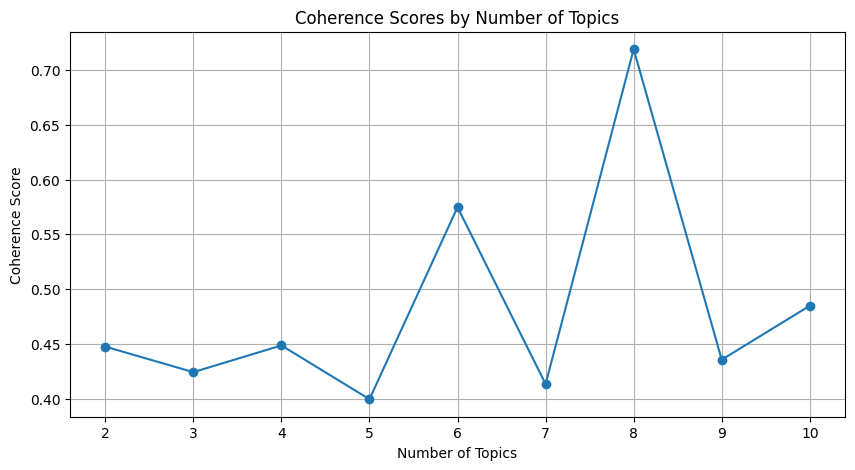

8

In [9]:
find_optimal_number_of_topics(corpus=abstracts, start=2, end=len(abstracts), step=1, num_words=7)

We can see that the optimal number of topics is 8. We will try and see the lda model with 8 topics.

In [10]:
from topic_modeling.lda import LDA
lda_model = LDA(corpus=abstracts, num_topics=8, num_words=7)
lda_model.fit()

In [11]:
# Print the generated topics
print(f'\n> Generated {len(lda_model.topics)} topics:')
for i, topic in enumerate(lda_model.topics):
    print(f'> Topic {i}: {topic}')


> Generated 8 topics:
> Topic 0: ['high', 'much', 'syntactic', 'learn', 'continuous', 'very', 'vector']
> Topic 1: ['high', 'much', 'syntactic', 'learn', 'continuous', 'very', 'vector']
> Topic 2: ['and', 'the', 'to', 'of', 'in', 'video', 'sora']
> Topic 3: ['pretraining', 'of', 'to', 'task', 'adaptive', 'domain', 'we']
> Topic 4: ['of', 'and', 'the', 'on', 'we', 'to', 'model']
> Topic 5: ['and', 'our', 'the', 'work', 'with', 'in', 'codebase']
> Topic 6: ['high', 'much', 'syntactic', 'learn', 'continuous', 'very', 'vector']
> Topic 7: ['high', 'much', 'syntactic', 'learn', 'continuous', 'very', 'vector']


We can see that some of the 8 topics are repeated, we can assume that there are only 6 topics, which is the second maxima found in the topic modeling coherence figure.

In [12]:
from topic_modeling.lda import LDA
lda_model = LDA(corpus=abstracts, num_topics=6, num_words=7)
lda_model.fit()

In [13]:
# Print the generated topics
print(f'\n> Generated {len(lda_model.topics)} topics:')
for i, topic in enumerate(lda_model.topics):
    print(f'> Topic {i}: {topic}')


> Generated 6 topics:
> Topic 0: ['high', 'based', 'observe', 'similarities', 'measured', 'vector', 'very']
> Topic 1: ['prediction', 'an', 'trust', 'predictions', 'classifier', 'one', 'explanations']
> Topic 2: ['and', 'the', 'to', 'of', 'in', 'video', 'sora']
> Topic 3: ['pretraining', 'of', 'to', 'task', 'adaptive', 'we', 'domain']
> Topic 4: ['of', 'and', 'the', 'on', 'we', 'to', 'model']
> Topic 5: ['and', 'our', 'the', 'work', 'in', 'with', 'codebase']


In [14]:
# Obtain the topic distributions for every document inside the corpus
lda_model.predict_all()

# Print the topic distributions for all the documents
print('\n> Topic distributions for all the documents:')
for doc_id, doc_info in enumerate(lda_model.topic_distributions):
    print(f'Document {doc_id}:')
    for topic_id, topic_dist in doc_info.items():
        print(f'> Topic {topic_id}: {topic_dist}')


> Topic distributions for all the documents:
Document 0:
> Topic 0: 0.0013022417207319654
> Topic 1: 0.0013021680174009603
> Topic 2: 0.001305713362396965
> Topic 3: 0.0013107402399422056
> Topic 4: 0.9934719743350049
> Topic 5: 0.0013071623245230182
Document 1:
> Topic 0: 0.000612813979480221
> Topic 1: 0.0006131442584745902
> Topic 2: 0.0006149106301507526
> Topic 3: 0.0006154429505435436
> Topic 4: 0.996929876520225
> Topic 5: 0.0006138116611258695
Document 2:
> Topic 0: 0.0006775804422499802
> Topic 1: 0.000678258115178066
> Topic 2: 0.0006789959029173259
> Topic 3: 0.0006801668030357857
> Topic 4: 0.9966054854765436
> Topic 5: 0.0006795132600751376
Document 3:
> Topic 0: 0.0009058592251503157
> Topic 1: 0.5761556652823262
> Topic 2: 0.0009125319737415425
> Topic 3: 0.0009101992760706619
> Topic 4: 0.42020622585884804
> Topic 5: 0.0009095183838632114
Document 4:
> Topic 0: 0.0009416554272261107
> Topic 1: 0.0009423418222459157
> Topic 2: 0.9952808184478326
> Topic 3: 0.00094423080